In [1]:
# https://data.worldbank.org/indicator/AG.LND.FRST.K2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import errors
import scipy.optimize as opt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skmet
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def worldbank_data(filename):
    """
    Read World Bank data from a CSV file.

    Args:
    - filename: The path to the CSV file.

    Returns:
    - df: The original DataFrame.
    - dft: Transposed DataFrame.
    """

    df = pd.read_csv(filename, skiprows=4)
    dft = df.transpose()
    dft.columns = dft.iloc[0]
    
    return df, dft

In [4]:
df, dft = worldbank_data('API_AG.LND.FRST.K2_DS2_en_csv_v2_6302271.csv')

In [5]:
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,Forest area (sq. km),AG.LND.FRST.K2,NaN,NaN,NaN,NaN,NaN,NaN,...,4.20,4.2,4.200,4.2,4.20,4.2,4.2,4.200,NaN,NaN
1,Africa Eastern and Southern,AFE,Forest area (sq. km),AG.LND.FRST.K2,NaN,NaN,NaN,NaN,NaN,NaN,...,4671832.12,4640642.5,4607876.100,4575901.2,4544314.78,4511676.2,4479395.0,4446875.546,NaN,NaN
2,Afghanistan,AFG,Forest area (sq. km),AG.LND.FRST.K2,NaN,NaN,NaN,NaN,NaN,NaN,...,12084.40,12084.4,12084.400,12084.4,12084.40,12084.4,12084.4,12084.400,NaN,NaN
3,Africa Western and Central,AFW,Forest area (sq. km),AG.LND.FRST.K2,NaN,NaN,NaN,NaN,NaN,NaN,...,1838300.32,1830344.0,1822960.779,1815608.1,1807898.60,1800220.1,1792580.7,1784915.233,NaN,NaN
4,Angola,AGO,Forest area (sq. km),AG.LND.FRST.K2,NaN,NaN,NaN,NaN,NaN,NaN,...,699377.52,693826.9,688276.200,682725.7,677175.10,671624.4,666073.8,660523.133,NaN,NaN


In [15]:
sub = df[['Country Name', 'Indicator Name'] + list(map(str, range(2001, 2022)))]
sub = sub.dropna()
subx = sub[["Country Name", "2021"]].copy()
subx.head()

,Country Name,2021
0,Aruba,4.200
1,Africa Eastern and Southern,4446875.546
2,Afghanistan,12084.400
3,Africa Western and Central,1784915.233
4,Angola,660523.133


In [16]:
subx["Growth"] = 100.0 * (sub["2021"] - sub["2001"]) / (sub["2001"])
subx.describe()

,2021,Growth
count,2.560000e+02,252.000000
mean,1.650154e+06,-0.885994
std,4.969469e+06,13.830658
min,0.000000e+00,-45.321846
25%,3.402075e+03,-7.489098
50%,3.647825e+04,0.000000
75%,2.830655e+05,4.173824
max,4.044947e+07,87.012987


In [18]:
def remove_outliers(data_frame, column_names):
    """
    Remove outliers from specified columns in the DataFrame.

    Returns:
    - Dataframe with outliers removed.
    """
    Q1 = data_frame[column_names].quantile(0.25)
    Q3 = data_frame[column_names].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    cleaned_data = data_frame[~((data_frame[column_names] < lower_bound) | (data_frame[column_names] > upper_bound)).any(axis=1)]
    return cleaned_data

subx = remove_outliers(subx, ["2021", "Growth"])

In [27]:
subx = subx.dropna()

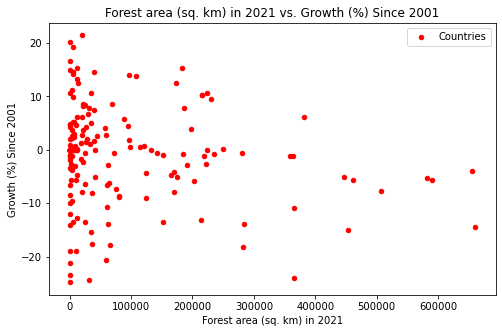

In [28]:
plt.figure(figsize=(8, 5))
scatter_plot = plt.scatter(subx["2021"], subx["Growth"], 20, label="Countries", c = 'red')
plt.xlabel("Forest area (sq. km) in 2021")
plt.ylabel("Growth (%) Since 2001")
plt.title("Forest area (sq. km) in 2021 vs. Growth (%) Since 2001")
plt.legend()
plt.show()

In [29]:
def normalize_data(data_frame, features):
    """
    Function to normalize the specified features using StandardScaler.
    
    """
    scaler = StandardScaler()
    subset_features = data_frame[features]
    scaler.fit(subset_features)
    normalized_data = scaler.transform(subset_features)
    normalized_df = pd.DataFrame(normalized_data, columns=features)

    return normalized_df, scaler

norm, scaler = normalize_data(subx, ['2021', 'Growth'])

In [36]:
def silhouette_score(xy, n):
    """
    Calculates silhouette score.

    Returns:
    Silhouette score.
    """
    kmeans = KMeans(n_clusters=n, init='k-means++', n_init=20)
    kmeans.fit(xy)
    labels = kmeans.labels_
    score = skmet.silhouette_score(xy, labels)
    return score

In [37]:
for i in range(2, 15):
    score = silhouette_score(norm, i)
    print(f"The silhouette score for {i: 3d} is {score: 7.4f}")

The silhouette score for   2 is  0.4538
The silhouette score for   3 is  0.4515
The silhouette score for   4 is  0.4604
The silhouette score for   5 is  0.5044
The silhouette score for   6 is  0.5105
The silhouette score for   7 is  0.4731
The silhouette score for   8 is  0.5176
The silhouette score for   9 is  0.4829
The silhouette score for  10 is  0.4912
The silhouette score for  11 is  0.4620
The silhouette score for  12 is  0.4813
The silhouette score for  13 is  0.4747
The silhouette score for  14 is  0.4664


In [39]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20)
kmeans.fit(norm)
labels = kmeans.labels_
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
xkmeans, ykmeans = centroids[:, 0], centroids[:, 1]

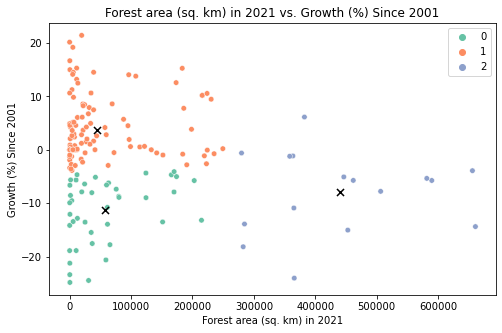

In [48]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=subx["2021"], y=subx["Growth"], hue=labels, palette="Set2", s=30)
plt.scatter(xkmeans, ykmeans, marker="x", c="black", s=50)
plt.xlabel("Forest area (sq. km) in 2021")
plt.ylabel("Growth (%) Since 2001")
plt.title("Forest area (sq. km) in 2021 vs. Growth (%) Since 2001")
plt.legend()
plt.show()

In [58]:
world = dft.loc['1960':'2022', ['World']].reset_index().rename(columns={'index': 'Year', 'World': 'Forest area (sq. km)'})
world = world.apply(pd.to_numeric, errors='coerce')
world = world.dropna()
world.describe()

Country Name,Year,Forest area (sq. km)
count,30.000000,3.000000e+01
mean,2006.500000,4.118018e+07
std,8.803408,4.696515e+05
min,1992.000000,4.044947e+07
25%,1999.250000,4.080500e+07
50%,2006.500000,4.115416e+07
75%,2013.750000,4.151248e+07
max,2021.000000,4.203424e+07


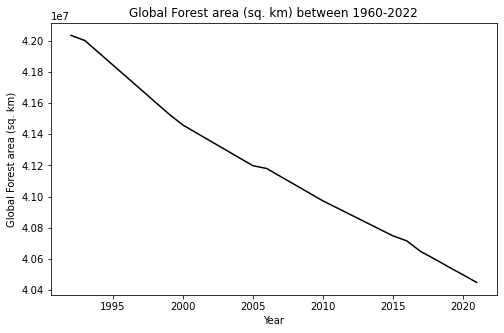

In [59]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=world, x='Year', y='Forest area (sq. km)', color = 'black')
plt.xlabel("Year")
plt.ylabel("Global Forest area (sq. km)")
plt.title("Global Forest area (sq. km) between 1960-2022")
plt.show()

In [64]:
def exponential(t, n0, g):
    """Calculates exponential function with scale factor n0 and growth rate g."""
    # makes it easier to get a guess for initial parameters
    t = t - 1990
    f = n0 * np.exp(g*t)
    return f

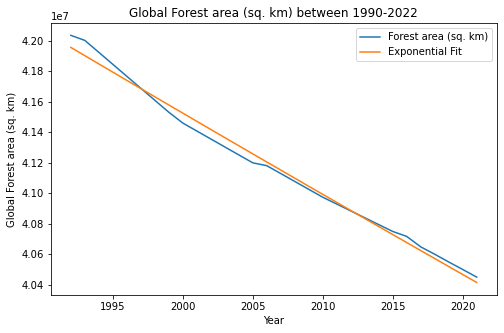

In [70]:
param, covar = opt.curve_fit(exponential, world["Year"], world["Forest area (sq. km)"], p0=(1e7, 0.1))
world["fit"] = exponential(world["Year"], *param)
plt.figure(figsize=(8, 5))
sns.lineplot(data=world, x="Year", y="Forest area (sq. km)", label="Forest area (sq. km)")
sns.lineplot(data=world, x="Year", y="fit", label="Exponential Fit")
plt.xlabel("Year")
plt.ylabel("Global Forest area (sq. km)")
plt.title("Global Forest area (sq. km) between 1990-2022")
plt.legend()
plt.show()

In [68]:
years = np.arange(2021, 2032, 1)
predictions = exponential(years, *param)
confidence_range = errors.error_prop(years, exponential, param, covar)

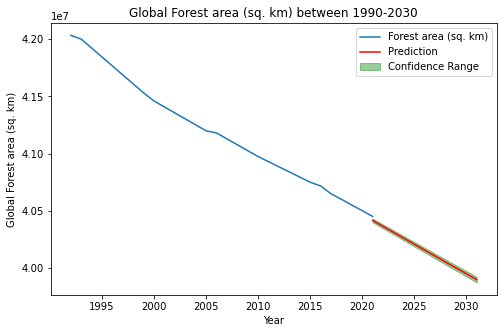

In [71]:
plt.figure(figsize=(8, 5))
sns.lineplot(x= world["Year"], y= world["Forest area (sq. km)"], label="Forest area (sq. km)")
sns.lineplot(x=years, y=predictions, label="Prediction", color='red')
plt.fill_between(years, predictions - confidence_range, predictions + confidence_range, color='green', alpha=0.4, label="Confidence Range")
plt.xlabel("Year")
plt.ylabel("Global Forest area (sq. km)")
plt.title("Global Forest area (sq. km) between 1990-2030")
plt.legend()
plt.show()